# Transfer Learning with TensorFlow Part 1 : Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our problem

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own
2. Can leverage a working nural network architecture which has already learnt patterns on similar data our own, then we can adapt those patterns on our own data



In [1]:
# Are we using GPU
!nvidia-smi

Mon Sep  4 13:57:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Downloading and becoming one with the data

In [1]:
# Get data (10% of 10 food classes from food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-09-04 14:07:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.31.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  39.5MB/s    in 4.7s    

2023-09-04 14:07:20 (34.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [3]:
# How many images in each folder
import os

# Walk through 10 percent data directory and list number of item
for dirpath,dirnames,filenames in os.walk("/content/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")


There are 2 directories and 0 images in /content/10_food_classes_10_percent
There are 10 directories and 0 images in /content/10_food_classes_10_percent/test
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in /content/10_food_classes_10_percent/test/pizza
There a

## Creating data loaders (preparing the data)

We will use the ImageDataGenerator class to load in our images in batches

In [15]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir = "/content/10_food_classes_10_percent/train/"
test_dir="/content/10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Training images :")

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical"
                                               )
print("Testing images :")

test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical"
                                               )

Training images :
Found 750 images belonging to 10 classes.
Testing images :
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

**Callbacks** are extra functionality that you can add to your models to be performed during or after training.

Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckPoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback



In [21]:
# Create Tensorboard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dirname,experiment_name):
  log_dir = dirname+"/"+experiment_name + "/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we have used TensorFlow to create our own models layer by layer from scratch

Now, we are going to do  a similar process, except majority of our model's layers are going to come from TensorFlow Hub

We can access pretrained models on: https://tfhub.dev/

If you want to learn which model is best on your problem you can visit https://paperswithcode.com/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model.
link : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [8]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [16]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url,num_classes=10):
  """
  Takes a TensorFlow Hub url and creates a Keras Sequential model with it.

  Args:
    model_url (str) : A tensorflow hub feature extraction URL
    num_classes (int) : the number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons
  """
  # Download the pretrained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE +(3,)
                                           )
  # Create the model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])

  return model

### Creating and testing Resnet TensorFlow Hub Feature Extraction Model


In [17]:
# Create Resnet model
resnet_model = create_model(resnet_url,num_classes=train_data.num_classes)

In [23]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"]
                     )

In [18]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [24]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dirname = "tensorflow_hub",
                                                                         experiment_name="resnet50V2")]
                                  )

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20230904-152629
Epoch 1/5
24/24 [==============================] - 27s 605ms/step - loss: 1.9928 - accuracy: 0.3253 - val_loss: 1.2168 - val_accuracy: 0.6128
Epoch 2/5
24/24 [==============================] - 12s 499ms/step - loss: 0.8956 - accuracy: 0.7453 - val_loss: 0.8464 - val_accuracy: 0.7220
Epoch 3/5
24/24 [==============================] - 12s 501ms/step - loss: 0.6201 - accuracy: 0.8227 - val_loss: 0.7403 - val_accuracy: 0.7568
Epoch 4/5
24/24 [==============================] - 13s 554ms/step - loss: 0.4710 - accuracy: 0.8933 - val_loss: 0.6977 - val_accuracy: 0.7768
Epoch 5/5
24/24 [==============================] - 11s 466ms/step - loss: 0.3782 - accuracy: 0.9187 - val_loss: 0.6625 - val_accuracy: 0.7856


Wow!

That is incredible. Our transfer learning feature extractor model out performed ALL of the previous models we buit by hand...(substantially) and in a quicker training time AND with only 10% of the training examples.

In [29]:
# Let's create a funttion to plot loss curves
import matplotlib.pyplot as plt

# Plot the validation and training curves

def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics

  Args:
    history: TensorFlow history object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs,loss,label="training loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


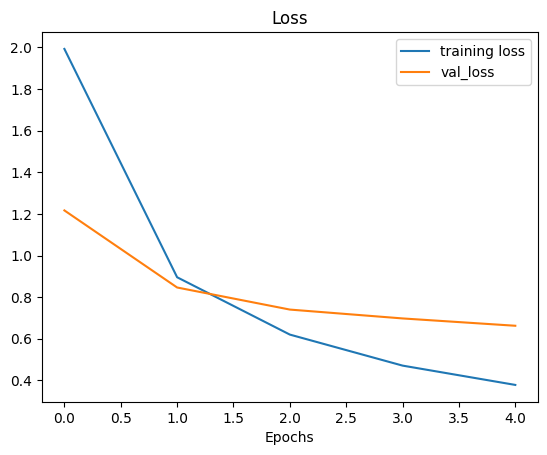

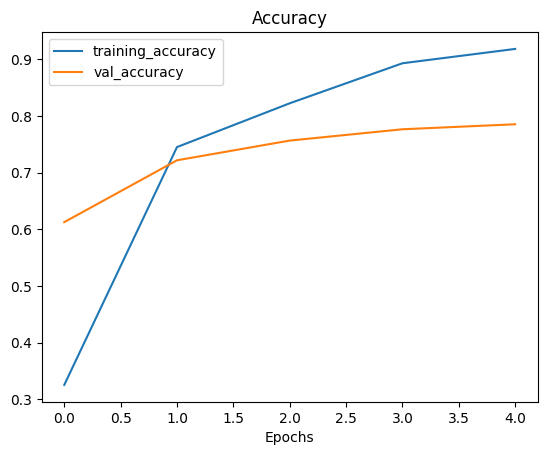

In [30]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction Model


In [31]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data.num_classes)

# compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"]
                     )
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dirname = "tensorflow_hub",
                                                                         experiment_name="efficientnetB0")]
                                  )

Saving Tensorboard log files to: tensorflow_hub/efficientnetB0/20230904-155124
Epoch 1/5
24/24 [==============================] - 27s 578ms/step - loss: 1.8110 - accuracy: 0.4453 - val_loss: 1.2635 - val_accuracy: 0.7380
Epoch 2/5
24/24 [==============================] - 13s 544ms/step - loss: 1.0385 - accuracy: 0.7827 - val_loss: 0.8462 - val_accuracy: 0.8228
Epoch 3/5
24/24 [==============================] - 11s 461ms/step - loss: 0.7425 - accuracy: 0.8507 - val_loss: 0.6823 - val_accuracy: 0.8528
Epoch 4/5
24/24 [==============================] - 11s 481ms/step - loss: 0.5941 - accuracy: 0.8680 - val_loss: 0.5955 - val_accuracy: 0.8640
Epoch 5/5
24/24 [==============================] - 10s 410ms/step - loss: 0.5055 - accuracy: 0.8933 - val_loss: 0.5470 - val_accuracy: 0.8656


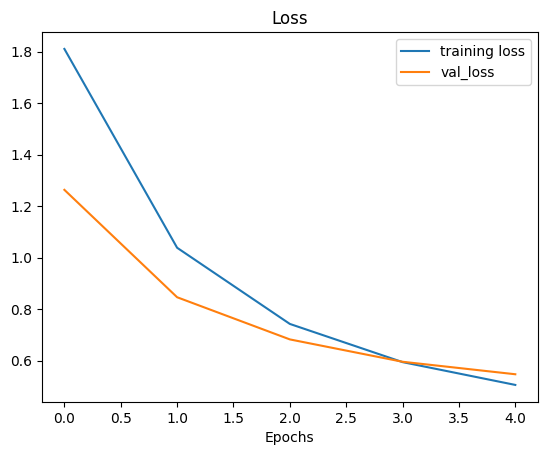

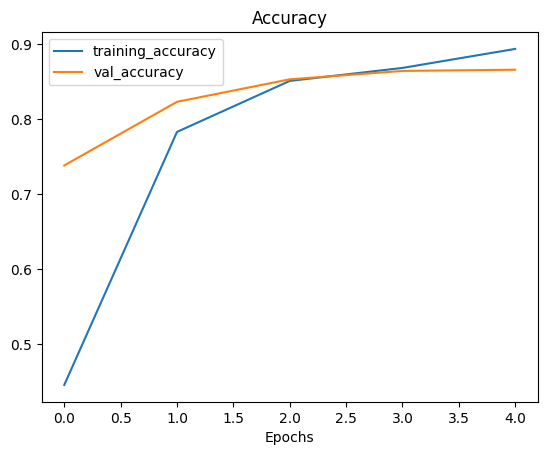

In [32]:
plot_loss_curves(efficientnet_history)

In [33]:
efficientnet_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [34]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [36]:
# How many layers does our efficientnetb0 feature extractor have ?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

*   **"As is"** transfer learning - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the pretrained patterns of an existing model (e.g efficientNetB0 trained on ImageNet and adjust the output layer  for your own problem)
* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)


## Comparing our models results using TensorBoard

**Note :** When you upload things to TensorBoard.dev you experiments are public. Therefore, if you are running private experiments (things you do not want to others to see ) do not upload them

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

Our Tensorboard experiments are uploaded publicly here : https://tensorboard.dev/experiment/fLXv3VeEQKe4cwCKbvg3gA/

In [52]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2023-09-04 16:27:52.984175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/fLXv3VeEQKe4cwCKbvg3gA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   fLXv3VeEQKe4cwCKbvg3gA
	Created              2023-09-04 16:23:14 (4 minutes ago)
	Updated              2023-09-04 16:23:18 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5813502
Total: 1 experiment(s)


In [ ]:
# Delete an experimet
# !tensorboard dev delete --experiment_id  (here copy the experiment id)